In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, shape
import geopandas as gpd
import pickle

# Import custom functions from `scripts` folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from scripts.clean_tweets import geometrize_tweets, convert_shapefile_crs, find_frequencies
from scripts.home_location import assign_home_location

np.random.seed(42)
pd.set_option('display.max_columns', 999)

# Loading data

In [116]:
ba12 = pd.read_csv('../data/tweets/ba_2012.csv')

/scratch/public/jsp/twitter-and-displacement/.env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [117]:
ba_shapefiles = gpd.read_file('../data/shapefiles/buenos_aires_shapefiles/BA_2010.shp')
ba_shapefiles = convert_shapefile_crs(ba_shapefiles)

# Filtering data and adding tracts

In [118]:
# Compute summary stats
num_tweets_12, num_users_12, median_tweets_12 = len(ba12), ba12['u_id'].nunique(), ba12.groupby('u_id').size().median()
percentile_99 = ba12.groupby('u_id').size().quantile(.99)

In [119]:
# Filter based on median tweets for 2012
ba12_filtered = ba12.groupby('u_id').filter(lambda group: (len(group) >= median_tweets_12) & (len(group) < percentile_99))

In [120]:
# Geometrize tweets based on lat/lon
ba12_filtered = geometrize_tweets(ba12_filtered)

In [121]:
# Add datetime
ba12_filtered['timestamp'] = pd.to_datetime(ba12_filtered['created_at'] // 1000, unit='s')
ba12_filtered['date'] = ba12_filtered['timestamp'].dt.date
ba12_filtered['hour'] = ba12_filtered['timestamp'].dt.hour

In [122]:
# Spatial join for tracts; add home locations
ba12_filtered = gpd.sjoin(ba12_filtered, ba_shapefiles, how='left', op='intersects')
ba12_filtered['home'] = assign_home_location(ba12_filtered, tract='codigo')
ba12_filtered['is_home'] = ba12_filtered['codigo'] == ba12_filtered['home']

/scratch/public/jsp/twitter-and-displacement/.env/lib/python3.7/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'proj': 'tmerc', 'lat_0': -34.6297166, 'lon_0': -58.4627, 'k': 1, 'x_0': 100000, 'y_0': 100000, 'ellps': 'intl', 'units': 'm', 'no_defs': True})
  '(%s != %s)' % (left_df.crs, right_df.crs))


In [2]:
# Save data for easy loading in future
# with open('../data/ba12_home.pkl', 'wb') as file:
#     pickle.dump(ba12_filtered, file, protocol=4)
with open('../data/ba12_home.pkl', 'rb') as file:
    ba12_filtered = pickle.load(file)


ba12_filtered['is_home'] = ba12_filtered['home'] == ba12_filtered['codigo']

In [58]:
# How many of the filtered tweets have a home assignment?
print((~ba12_filtered['home'].isnull()).mean())

0.016204896553992567


In [59]:
# Ratio of users that have home location
ba12_filtered.groupby(['u_id']).first()['is_home'].mean()

0.007069461570078093

In [60]:
# Ratio of filtered 2012 tweets in which tweet was made from home tract 
ba12_filtered['is_home'].mean()

0.011788568859846284

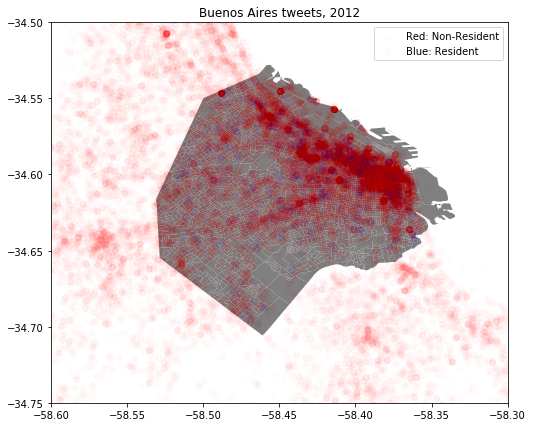

In [52]:
### Plot 5% of 2012 tweets
# Blue tweets: Resident
# Red tweets: Non-resident
# Gray (barely visible beneath the blue): Buenos Aires shapefile
fig, ax = plt.subplots(figsize=(10, 7))
ba_shapefiles['geometry'].plot(ax=ax, color='gray')
smpl = ba12_filtered.sample(frac=0.05, random_state=42)
smpl[~smpl['is_home']].plot(ax=ax, marker='o', color='red', alpha=0.01, label='Red: Non-Resident')
smpl[smpl['is_home']].plot(ax=ax, marker='o', color='blue', alpha=0.01, label='Blue: Resident')
plt.legend()
plt.axis([-58.6, -58.3, -34.75, -34.5])
plt.title('Buenos Aires tweets, 2012');

# min_hours == 0

In [34]:
# Save data for easy loading in future
# with open('../data/ba12_home.pkl', 'wb') as file:
#     pickle.dump(ba12_filtered, file, protocol=4)
# with open('../data/ba12_home.pkl', 'rb') as file:
#     ba12_filtered = pickle.load(file)

ba12_filtered['home'] = assign_home_location(ba12_filtered, tract='codigo', min_hours=0)
ba12_filtered['is_home'] = ba12_filtered['home'] == ba12_filtered['codigo']

In [35]:
# How many of the filtered tweets have a home assignment?
print((~ba12_filtered['home'].isnull()).mean())

0.23383759562671458


In [36]:
# Ratio of users that have home location
ba12_filtered.groupby(['u_id']).first()['is_home'].mean()

0.045288439728823814

In [37]:
# Ratio of filtered 2012 tweets in which tweet was made from home tract 
ba12_filtered['is_home'].mean()

0.10150795461106991

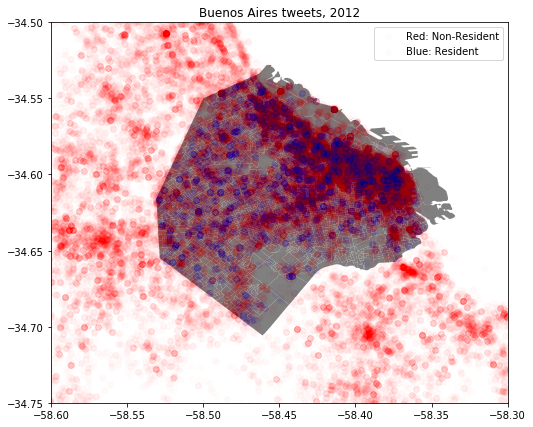

In [38]:
### Plot 5% of 2012 tweets
# Blue tweets: Resident
# Red tweets: Non-resident
# Gray (barely visible beneath the blue): Buenos Aires shapefile
fig, ax = plt.subplots(figsize=(10, 7))
ba_shapefiles['geometry'].plot(ax=ax, color='gray')
smpl = ba12_filtered.sample(frac=0.05, random_state=42)
smpl[~smpl['is_home']].plot(ax=ax, marker='o', color='red', alpha=0.01, label='Red: Non-Resident')
smpl[smpl['is_home']].plot(ax=ax, marker='o', color='blue', alpha=0.01, label='Blue: Resident')
plt.legend()
plt.axis([-58.6, -58.3, -34.75, -34.5])
plt.title('Buenos Aires tweets, 2012');

In [20]:
(
    ba12_filtered
    .loc[:, ['codigo', 'is_home']]
    .groupby('codigo')
    .agg([len, np.mean])
    .rename(columns={'len':'count', 'mean':'home_tweet_ratio'})
).to_csv('../data/ba12_home_by_codigo.csv')

# Filtering

In [123]:
# Save data for easy loading in future
# with open('../data/ba12_home.pkl', 'wb') as file:
#     pickle.dump(ba12_filtered, file, protocol=4)
# with open('../data/ba12_home.pkl', 'rb') as file:
#     ba12_filtered = pickle.load(file)

ba12_filtered['home'] = assign_home_location(ba12_filtered, tract='codigo')
ba12_filtered['is_home'] = ba12_filtered['home'] == ba12_filtered['codigo']

In [71]:
# How many of the filtered tweets have a home assignment?
print((~ba12_filtered.loc[~ba12_filtered['codigo'].isnull(), 'home'].isnull()).mean())

0.4320654367211751


In [72]:
# Ratio of users that have home location
ba12_filtered[~ba12_filtered['codigo'].isnull()].groupby(['u_id']).first()['is_home'].mean()

0.062141779788838614

In [73]:
# Ratio of filtered 2012 tweets in which tweet was made from home tract 
ba12_filtered.loc[~ba12_filtered['codigo'].isnull(), 'is_home'].mean()

0.21518000510868296

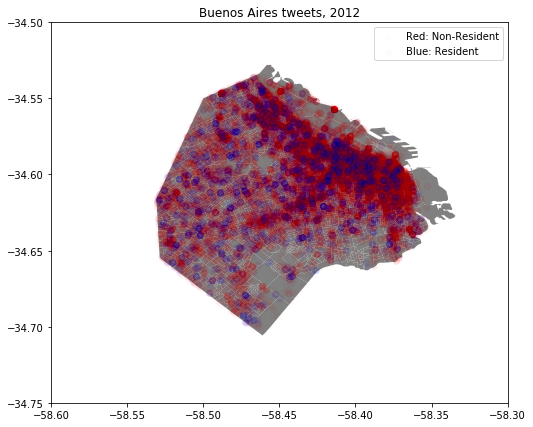

In [74]:
### Plot 5% of 2012 tweets
# Blue tweets: Resident
# Red tweets: Non-resident
# Gray (barely visible beneath the blue): Buenos Aires shapefile
fig, ax = plt.subplots(figsize=(10, 7))
ba_shapefiles['geometry'].plot(ax=ax, color='gray')
smpl = ba12_filtered[~ba12_filtered['codigo'].isnull()].sample(frac=0.05, random_state=42)
smpl[~smpl['is_home']].plot(ax=ax, marker='o', color='red', alpha=0.01, label='Red: Non-Resident')
smpl[smpl['is_home']].plot(ax=ax, marker='o', color='blue', alpha=0.01, label='Blue: Resident')
plt.legend()
plt.axis([-58.6, -58.3, -34.75, -34.5])
plt.title('Buenos Aires tweets, 2012');

In [75]:
(
    ba12_filtered
    .loc[:, ['codigo', 'is_home']]
    .groupby('codigo')
    .agg([len, np.mean])
    .rename(columns={'len':'count', 'mean':'home_tweet_ratio'})
).to_csv('../data/ba12_home_by_codigo_99_removed.csv')

In [124]:
ba12_filtered.head()

,id,u_id,lat,lon,created_at,type,place_type,u_created_at,u_followers_count,u_location,u_lang,u_statuses_count,u_name,u_screen_name,u_description,urls,text,geometry,timestamp,date,hour,index_right,Shape_Leng,Shape_Area,BARRIOS,COMUNA,codigo,home,is_home
0,227552828854517761,286204686,-34.615267,-58.838874,1343087796000,ll,NaN,1303484737000,766,Orgullosamente Arshentina,es,1603,River+Jonas=My♥,ayelenjonass,Soy ayelen soy jonatica fan @jonasbrothers @dd...,NaN,Un hombre tiene la razón hasta que se demuestr...,POINT (-58.8388738 -34.615267),2012-07-23 23:56:36,2012-07-23,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,227553127031783425,290364810,-34.421520,-58.726667,1343087867000,ll,NaN,1304139296000,59,NaN,es,1466,yami suarez,yamii_suarez,NaN,NaN,No me contestes :/,POINT (-58.72666700000001 -34.4215196),2012-07-23 23:57:47,2012-07-23,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,227553906417356800,175518563,-34.622320,-58.477805,1343088053000,ll,NaN,1281127957000,387,NaN,es,3912,Luli Zuluaga,lulizuluaga,Dance dance dance,NaN,Tengo los ovarios inflados de todo el mundo po...,POINT (-58.477805 -34.62232),2012-07-24 00:00:53,2012-07-24,0,566.0,1046.968078,54830.843261,VILLA SANTA RITA,11.0,20111809.0,NaN,False
5,227555804952276992,520915990,-34.595658,-58.497741,1343088506000,ll,NaN,1331431416000,6,buenos aires argentina,es,174,julian losada,julian095,NaN,NaN,Uhhh como voy a dormir hoy por dios,POINT (-58.49774118 -34.59565765),2012-07-24 00:08:26,2012-07-24,0,1720.0,902.903680,36777.900360,AGRONOMIA,15.0,20150602.0,NaN,False
7,227557033048678400,163650310,-34.478360,-58.652150,1343088799000,ll,NaN,1278459265000,184,"Argentna, Buenos Aires",es,17810,Chackuu ♡,jacquigrob,29116F35,NaN,Elegi: A-queres ser mi novio; B-a; C-b; y si n...,POINT (-58.65215 -34.47836),2012-07-24 00:13:19,2012-07-24,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [125]:
def save_data(data, year):
    parque = data[(data['BARRIOS'] == 'PARQUE PATRICIOS') | 
                  (data['codigo'].isin([20041001, 20012905, 20032309]))]
    boca = data[(data['BARRIOS'] == 'BOCA') & (data['codigo'] != 20041801)]
    
    parque.to_csv('../ba_' + str(year) + '_PARQUE_PATRICIOS.csv', index=False)
    boca.to_csv('../ba_' + str(year) + '_BOCA.csv', index=False)

In [126]:
save_data(ba12_filtered, 2012)